In [ ]:
!unzip uw-cs480-fall20.zip

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string

def clean_text(text):
  translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation)) #map punctuation to space
  new_txt = text.translate(translator)
  new_txt = new_txt.lower() 
  return new_txt

# prepare train dataset
train_data = pd.read_csv("train.csv")
train_data['noisyTextDescription'] = train_data['noisyTextDescription'].apply(clean_text)
train_category = train_data.category
train_txt = train_data.noisyTextDescription
classification = (pd.unique(train_category)).tolist()
y = list(map(lambda c: np.array([classification.index(c)]), train_category))
y_train = np.array(y)


# prepare test dataset
test_data = pd.read_csv("test.csv")
test_data['noisyTextDescription'] = test_data['noisyTextDescription'].apply(clean_text)
test_id = test_data.id
test_txt = test_data.noisyTextDescription


x_train shape: (21627, 1000)
x_test shape: (21628, 1000)
y_train shape: (21627, 27)
Epoch 1/10
555/557 [============================>.] - ETA: 0s - loss: 0.9559 - accuracy: 0.7688
Epoch 00001: val_accuracy improved from -inf to 0.89629, saving model to best_model.h5
557/557 [==============================] - 3s 6ms/step - loss: 0.9546 - accuracy: 0.7691 - val_loss: 0.3893 - val_accuracy: 0.8963
Epoch 2/10
556/557 [============================>.] - ETA: 0s - loss: 0.3483 - accuracy: 0.9066
Epoch 00002: val_accuracy improved from 0.89629 to 0.90700, saving model to best_model.h5
557/557 [==============================] - 3s 5ms/step - loss: 0.3483 - accuracy: 0.9066 - val_loss: 0.3246 - val_accuracy: 0.9070
Epoch 3/10
552/557 [============================>.] - ETA: 0s - loss: 0.2724 - accuracy: 0.9209
Epoch 00003: val_accuracy improved from 0.90700 to 0.91014, saving model to best_model.h5
557/557 [==============================] - 3s 5ms/step - loss: 0.2728 - accuracy: 0.9207 - val_loss

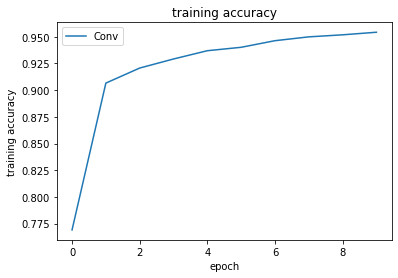

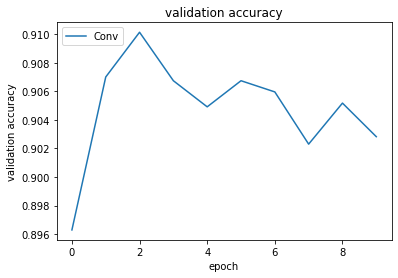

In [ ]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 10

# normalize dataset
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

tokenize.fit_on_texts(train_txt) # only fit on train
x_train = tokenize.texts_to_matrix(train_txt)
x_test = tokenize.texts_to_matrix(test_txt)

num_classes = 27
y_train = utils.to_categorical(y_train, num_classes)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# create a callback that will save the best model while training
save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.177,
                    callbacks=[save_best_model])

# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()


In [ ]:
# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
saved_model = load_model('best_model.h5')
predictions = saved_model.predict(x_test)
print(predictions)


[[3.7167206e-06 2.2883480e-05 8.1832295e-05 ... 3.9791492e-05
  1.9797080e-06 4.8747584e-06]
 [7.7776558e-06 2.3672566e-05 9.9917245e-01 ... 1.6517275e-05
  3.1789372e-05 1.1635644e-06]
 [8.4411289e-04 1.0571893e-03 6.9297333e-03 ... 7.9552522e-03
  3.0226351e-04 2.0930902e-03]
 ...
 [3.7327460e-05 4.2919558e-04 9.9436861e-01 ... 8.0937862e-05
  8.4666535e-04 2.0121546e-05]
 [1.4324690e-06 1.0592834e-05 1.2432410e-04 ... 5.5074077e-05
  2.6811656e-06 5.1928087e-06]
 [9.6495814e-06 7.1757728e-05 5.4552413e-05 ... 8.3672829e-05
  3.2424148e-06 3.3227241e-04]]


In [ ]:
classes = np.argmax(predictions, axis = 1)
predicted_categories = list(map(lambda i: classification[i], classes))
result = {"id":test_id,  "category":predicted_categories}
df = pd.DataFrame(result)
df.to_csv('submission_text.csv', index=False)